# **NOTE: that running this notebook will take TENS of minutes due to the OMDB API calls!**
220k rows of OMDB API calls ia lmost 8 hours

## Load Dependencies

In [1]:
import pandas as pd
import requests
from requests.exceptions import ReadTimeout
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Load IMDB data from SQL output

In [2]:
ratings_df = pd.read_csv('../Resources/IMDB_SQL_Ratings.csv')
print(f'ratings_df length: {len(ratings_df)}')
ratings_df.head(3)

ratings_df length: 224198


,tconst,averagerating,numvotes
0,tt0013274,6.8,59
1,tt0015414,5.2,16
2,tt0015724,6.1,27


In [3]:
titles_df = pd.read_csv('../Resources/IMDB_SQL_Titles.csv')
print(f'titles_df length: {len(titles_df)}')
titles_df.head(3)

titles_df length: 404054


,tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
0,tt10048376,movie,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,0,2019,N,101,Drama
1,tt10048408,movie,La ola de crímenes,La ola de crímenes,0,2017,N,70,Drama
2,tt10048556,movie,Staged Killer,Staged Killer,0,2019,N,88,Thriller


In [4]:
# Merge the two dataframes into one
imdb_df = pd.merge(titles_df, ratings_df, on='tconst', how='inner')
print(f'imdb_df length: {len(imdb_df)}')
imdb_df.head(3)

imdb_df length: 224198


,tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres,averagerating,numvotes
0,tt10048376,movie,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,0,2019,N,101,Drama,4.8,30
1,tt10048556,movie,Staged Killer,Staged Killer,0,2019,N,88,Thriller,3.7,340
2,tt10049110,movie,Die Wiese,Die Wiese,0,2019,N,93,Documentary,7.8,96


In [5]:
# Convert what should be numeric columns to numerics
# Using errors='coerce' to drop the values such as "N"
imdb_df[['endyear', 'runtimeminutes', 'numvotes']] = imdb_df[['endyear', 'runtimeminutes', 'numvotes']].apply(pd.to_numeric, errors='coerce')
imdb_df.dtypes

tconst             object
titletype          object
primarytitle       object
originaltitle      object
isadult             int64
startyear           int64
endyear           float64
runtimeminutes    float64
genres             object
averagerating     float64
numvotes            int64
dtype: object

In [6]:
# Keep required columns only and rename for readability
imdb_df = imdb_df[['tconst', 'averagerating', 'numvotes', 'isadult', 'startyear', 'runtimeminutes', 'genres', 'primarytitle']]
imdb_df.rename(columns={'averagerating':'averageRating', 'numvotes':'numVotes', 'isadult':'isAdult', 'startyear':'startYear', 
                        'runtimeminutes':'runtimeMinutes', 'primarytitle':'Movie'}, inplace=True)
imdb_df.head(3)

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie
0,tt10048376,4.8,30,0,2019,101.0,Drama,Ya podaryu tebe pobedu
1,tt10048556,3.7,340,0,2019,88.0,Thriller,Staged Killer
2,tt10049110,7.8,96,0,2019,93.0,Documentary,Die Wiese


# Pull the OMDBAPI Data

**NOTE THIS QUERY TAKES HOURS TO COMPLETE**

In [7]:
# Define the OMDB API Call
api_key = 'ac6cb27f'
omdb_url = 'http://www.omdbapi.com/'

def get_movie_details(imdb_id):
    params = {'apikey': api_key, 'i': imdb_id}
    
    # Set a maximum number of retries
    max_retries = 3
    
    for _ in range(max_retries):
        try:
            response = requests.get(omdb_url, params=params, timeout=(5, 10))  # Set timeout values as needed
            response.raise_for_status()  # Raise an exception for HTTP errors (4xx and 5xx)
            data = response.json()
            return data
        except ReadTimeout:
            print(f"Read timeout occurred for movie with IMDb ID {imdb_id}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break  # Break out of the loop for other types of exceptions
    
    # Handle the case where the request was unsuccessful after retries
    print(f"Unable to fetch data for movie with IMDb ID {imdb_id}")
    return None

# Define the fields to extract
fields_to_extract = ['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 
                     'Writer', 'Actors', 'Language', 'Country', 'Type', 'Metascore', 
                     'imdbRating', 'imdbVotes', 'BoxOffice', 'Production']

# Create a Copy of the IMDB df and ddd new columns to dataframe
df = imdb_df.copy()
for field in fields_to_extract:
    df[f'OMDB_{field}'] = np.nan

In [8]:
# Grab start time
start_time = time.time()

# Iterate through each row in the DataFrame and append selected fields from the API response
for index, row in df.iterrows():
    # Print an update on progress as it processes
    if index%10000 == 0:
        print(f'working on index: {index}')
    
    # Check if the relevant fields are already populated
    if all(pd.notna(row[f'OMDB_{field}']) for field in fields_to_extract):
        continue  # Skip making API call for rows where data is already present
    
    movie_title = row['tconst']
    movie_details = get_movie_details(movie_title)

    # Check if movie details were retrieved successfully
    if movie_details:
        # Append selected fields to the DataFrame
        for field in fields_to_extract:
            column_name = f'OMDB_{field}'
            df.at[index, column_name] = movie_details.get(field, '')
    else:
        # Handle the case where movie details were not retrieved
        # You can choose to skip the row, set default values, or handle it in another way
        pass

# Print time taken
print("--- %s minutes ---" % round(((time.time() - start_time)/60),2))

working on index: 0
working on index: 10000
working on index: 20000
working on index: 30000
working on index: 40000
working on index: 50000
working on index: 60000
working on index: 70000
working on index: 80000
working on index: 90000
working on index: 100000
Read timeout occurred for movie with IMDb ID tt4526792. Retrying...
Error: 502 Server Error: Bad Gateway for url: http://www.omdbapi.com/?apikey=ac6cb27f&i=tt4652164
Unable to fetch data for movie with IMDb ID tt4652164
Error: 502 Server Error: Bad Gateway for url: http://www.omdbapi.com/?apikey=ac6cb27f&i=tt4718104
Unable to fetch data for movie with IMDb ID tt4718104
Error: 502 Server Error: Bad Gateway for url: http://www.omdbapi.com/?apikey=ac6cb27f&i=tt4826734
Unable to fetch data for movie with IMDb ID tt4826734
Error: 502 Server Error: Bad Gateway for url: http://www.omdbapi.com/?apikey=ac6cb27f&i=tt4854126
Unable to fetch data for movie with IMDb ID tt4854126
Error: 502 Server Error: Bad Gateway for url: http://www.omdbap

In [10]:
df.to_csv("../Resources/IMDB_OMDB_movies_raw.csv")

# Format column data types from objects to numbers

In [11]:
# # Import and read the data if you screwed up :)
# movies_df = pd.read_csv("../Resources/IMDB_OMDB_movies_raw.csv")
# movies_df = movies_df[['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear', 'runtimeMinutes', 
#                        'genres', 'Movie', 'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 
#                        'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 
#                        'OMDB_Type', 'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 
#                        'OMDB_BoxOffice', 'OMDB_Production']]
# movies_df.head()

In [12]:
# Examine data type of each column
movies_df=df
movies_df.dtypes

tconst              object
averageRating      float64
numVotes             int64
isAdult              int64
startYear            int64
runtimeMinutes     float64
genres              object
Movie               object
OMDB_Title          object
OMDB_Rated          object
OMDB_Released       object
OMDB_Runtime        object
OMDB_Genre          object
OMDB_Director       object
OMDB_Writer         object
OMDB_Actors         object
OMDB_Language       object
OMDB_Country        object
OMDB_Type           object
OMDB_Metascore      object
OMDB_imdbRating     object
OMDB_imdbVotes      object
OMDB_BoxOffice      object
OMDB_Production     object
dtype: object

In [13]:
# delate all "N/A"
movies_df = movies_df.replace('N/A', '')

# Convert $ objects to floats
movies_df[['OMDB_BoxOffice']] = movies_df[['OMDB_BoxOffice']].replace('[\$,\s]', '', regex=True)
movies_df[['OMDB_BoxOffice']] = movies_df[['OMDB_BoxOffice']].apply(pd.to_numeric, errors='coerce')

# Convert number strings with comma to float
movies_df[['OMDB_imdbVotes']] = movies_df[['OMDB_imdbVotes']].replace('[,\s]', '', regex=True)
movies_df['OMDB_imdbVotes'] = pd.to_numeric(movies_df['OMDB_imdbVotes'], errors='coerce')

# Convert runtime to float after removing " min"
movies_df[['OMDB_Runtime']] = movies_df[['OMDB_Runtime']].replace('[min\s]', '', regex=True)
movies_df['OMDB_Runtime'] = pd.to_numeric(movies_df['OMDB_Runtime'], errors='coerce')

# Convert the number strings to numeric
movies_df[['OMDB_imdbRating', 'OMDB_Metascore']] = movies_df[['OMDB_imdbRating', 'OMDB_Metascore']].apply(pd.to_numeric, errors='coerce')

# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])

movies_df.dtypes

tconst                     object
averageRating             float64
numVotes                    int64
isAdult                     int64
startYear                   int64
runtimeMinutes            float64
genres                     object
Movie                      object
OMDB_Title                 object
OMDB_Rated                 object
OMDB_Released      datetime64[ns]
OMDB_Runtime              float64
OMDB_Genre                 object
OMDB_Director              object
OMDB_Writer                object
OMDB_Actors                object
OMDB_Language              object
OMDB_Country               object
OMDB_Type                  object
OMDB_Metascore            float64
OMDB_imdbRating           float64
OMDB_imdbVotes            float64
OMDB_BoxOffice            float64
OMDB_Production            object
dtype: object

In [14]:
movies_df.to_csv("../Resources/IMDB_OMDB_formatted.csv")

# Minor Processing

## Convert dates into year and month columns removing date columns

In [ ]:
# # Import and read the data if you screwed up :)
# movies_df = pd.read_csv("../Resources/IMDB_OMDB_formatted.csv")
# movies_df = movies_df[['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear', 'runtimeMinutes', 
#                        'genres', 'Movie', 'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime', 'OMDB_Genre', 
#                        'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 
#                        'OMDB_Type', 'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 
#                        'OMDB_BoxOffice', 'OMDB_Production']]
# movies_df.head()

In [15]:
# Change date to datetime type (Note "ReleaseDate" has inconsistent formatting / typos)
movies_df["OMDB_Released"] = pd.to_datetime(movies_df["OMDB_Released"])
movies_df

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,OMDB_Rated,...,OMDB_Writer,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Type,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production
0,tt10048376,4.8,30,0,2019,101.0,Drama,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,,...,Arsen Agadzhanyan,"Tigran Agadzhanyan, Maria Atlas, Valeriy Barinov",Russian,Russia,movie,NaN,5.1,22.0,NaN,
1,tt10048556,3.7,340,0,2019,88.0,Thriller,Staged Killer,Staged Killer,TV-14,...,"Lindsay Hartley, Jason-Shane Scott","Chrishell Stause, Nicole Bilderback, Jason Dolley",English,United States,movie,NaN,3.7,339.0,NaN,
2,tt10049110,7.8,96,0,2019,93.0,Documentary,Die Wiese,Die Wiese,,...,"Jan Haft, Michael Miersch",Sebastian Winkler,German,Germany,movie,NaN,7.8,95.0,NaN,
3,tt10049238,7.1,41,0,2018,61.0,Documentary,Joan Miró: The Inner Fire,Miró contra Miró,,...,,"Hester Wilcox, Joan Miró, Joan Punyet Miró","Spanish, French, English","France, Spain",movie,NaN,7.0,32.0,NaN,
4,tt10049262,5.4,176,0,2020,107.0,"Comedy,Romance",James & Pat & Dave,James & Pat & Dave,,...,"Daisy Cayanan, Marionne Dominique Mancol","Ronnie Alonte, Loisa Andalio, Donny Pangilinan","Tagalog, Filipino",Philippines,movie,NaN,5.4,174.0,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224193,tt10047128,6.4,5,0,2015,90.0,Drama,De hormigón armado,De hormigón armado,,...,Felipe Restrepo,"Román Tanoni, Lucila Madeo, Pablo Pili, Esteba...",Spanish,Argentina,movie,NaN,NaN,NaN,NaN,
224194,tt10047356,5.5,15,0,2018,92.0,Mystery,Eises Kälte - Frozen in Time,Eises Kälte - Frozen in Time,,...,"Klaus Korman, Klaus Uhlenbrock","Isabelle Aring, Andre Brüggemann, Marjorie Hag...",German,Germany,movie,NaN,5.1,15.0,NaN,
224195,tt10047904,6.9,844,0,2022,104.0,"Drama,Horror",Darkling,Darkling,,...,Dusan Milic,"Danica Curcic, Darren Pettie, Slavko Stimac","Serbian, English, Italian","Serbia, Denmark, Bulgaria, Greece, Italy",movie,NaN,6.9,820.0,NaN,
224196,tt10047958,3.5,4628,0,2021,90.0,"Comedy,Fantasy",Bad President,Bad President,,...,"John Buchanan, Param Gill","Eddie Griffin, Robert Amico, Zang Angelfire",English,United States,movie,NaN,3.5,4626.0,NaN,


In [16]:
movies_df.dtypes

tconst                     object
averageRating             float64
numVotes                    int64
isAdult                     int64
startYear                   int64
runtimeMinutes            float64
genres                     object
Movie                      object
OMDB_Title                 object
OMDB_Rated                 object
OMDB_Released      datetime64[ns]
OMDB_Runtime              float64
OMDB_Genre                 object
OMDB_Director              object
OMDB_Writer                object
OMDB_Actors                object
OMDB_Language              object
OMDB_Country               object
OMDB_Type                  object
OMDB_Metascore            float64
OMDB_imdbRating           float64
OMDB_imdbVotes            float64
OMDB_BoxOffice            float64
OMDB_Production            object
dtype: object

In [17]:
movies_df["ReleaseYear"] = pd.DatetimeIndex(movies_df['OMDB_Released']).year
movies_df["ReleaseMonth"] = pd.DatetimeIndex(movies_df['OMDB_Released']).month
movies_df = movies_df.drop(['OMDB_Released'], axis=1)
movies_df.head()

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,OMDB_Rated,...,OMDB_Language,OMDB_Country,OMDB_Type,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth
0,tt10048376,4.8,30,0,2019,101.0,Drama,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,,...,Russian,Russia,movie,NaN,5.1,22.0,NaN,,2019.0,4.0
1,tt10048556,3.7,340,0,2019,88.0,Thriller,Staged Killer,Staged Killer,TV-14,...,English,United States,movie,NaN,3.7,339.0,NaN,,2019.0,6.0
2,tt10049110,7.8,96,0,2019,93.0,Documentary,Die Wiese,Die Wiese,,...,German,Germany,movie,NaN,7.8,95.0,NaN,,2019.0,4.0
3,tt10049238,7.1,41,0,2018,61.0,Documentary,Joan Miró: The Inner Fire,Miró contra Miró,,...,"Spanish, French, English","France, Spain",movie,NaN,7.0,32.0,NaN,,2018.0,10.0
4,tt10049262,5.4,176,0,2020,107.0,"Comedy,Romance",James & Pat & Dave,James & Pat & Dave,,...,"Tagalog, Filipino",Philippines,movie,NaN,5.4,174.0,NaN,,2020.0,2.0


In [18]:
movies_df.columns

Index(['tconst', 'averageRating', 'numVotes', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'Movie', 'OMDB_Title', 'OMDB_Rated',
       'OMDB_Runtime', 'OMDB_Genre', 'OMDB_Director', 'OMDB_Writer',
       'OMDB_Actors', 'OMDB_Language', 'OMDB_Country', 'OMDB_Type',
       'OMDB_Metascore', 'OMDB_imdbRating', 'OMDB_imdbVotes', 'OMDB_BoxOffice',
       'OMDB_Production', 'ReleaseYear', 'ReleaseMonth'],
      dtype='object')

# Investigate Inputs / Features: should any be consolidated or truncated

In [20]:
# Check distribution of type
movies_df['OMDB_Type'].value_counts()

movie      224162
series         10
episode         9
                4
game            1
Name: OMDB_Type, dtype: int64

In [21]:
# Remove the non-movies
movies_df = movies_df[movies_df['OMDB_Type'] == 'movie']
# Remove the type column from the dataframe
movies_df = movies_df.drop(['OMDB_Type'], axis=1)

In [22]:
# Check distribution of ratings
ratings_count = movies_df['OMDB_Rated'].value_counts()
ratings_count

             162839
Not Rated     23719
R             15445
PG-13          5585
PG             4025
              ...  
PG13              1
R15+              1
All               1
18A               1
F                 1
Name: OMDB_Rated, Length: 96, dtype: int64

In [23]:
# Define Consolidate Rated Lists:
# reference https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system and Google for odd ones
kids = ['PG', 'G', 'TV-PG', 'TV-G', 'GP', 'M/PG', 'M', 'TV-Y7', 'U', 'TV-Y', 'Atp', 'Btl', 'E', 'TV-Y7-FV', '7', 'o.Al.', '6', 'Open', 'K-3', 'KT', 'UA', 'L', 'I', 'M/6', '7+', 'A.G.', 'All', 'K-8']
teens = ['PG-13', 'TV-14', '16+', '13+', '12', '13', '16', 'T', 'E10+', '11', '15', '14', 'M/12', 'MA-13', 'M/16', '-16', 'K-12', 'TV-13', '12A', 'PG-12', '10', 'K-16', 'IIA', 'PG13', 'R15+', 'II', 'K-13', 'KNT', 'K-14']
adults = ['R', 'TV-MA', 'NC-17', 'X', '18+', 'AO', '18', 'S', 'III', 'A', 'IIB', 'M/18', 'K-18', 'R-18', 'MA-17', 'M18', 'C', 'R18+', 'VM18', '18A', 'BPjM Restricted', 'R-18+', 'R(A)']
Unknown = ['Not Rated', 'Approved', 'Unrated', 'Passed', 'NOT RATED', 'UNRATED', 'APPROVED', '(Banned)', 'PASSED', 'EM', 'AL', 'F', 'B', 'Livre', 'K']

for index, row in movies_df.iterrows():
    movie_rating = row['OMDB_Rated']
    if movie_rating in kids:
        movies_df.at[index,'OMDB_Rated'] = 'kids'
    elif movie_rating in teens:
        movies_df.at[index,'OMDB_Rated'] = 'teens'
    elif movie_rating in adults:
        movies_df.at[index,'OMDB_Rated'] = 'adults'
    else:
        movies_df.at[index,'OMDB_Rated'] = 'unknown'

# df["grade"] = df.apply(lambda x: 'A+' if ((x['score']>40)&(x['score']<50)) else x["grade"], axis=1)
# movies_df.OMDB_Rated = np.where((movies_df.OMDB_Rated in kids), 'kids', movies_df.OMDB_Rated)

movies_df['OMDB_Rated'].value_counts()

unknown    189734
adults      19417
teens        8068
kids         6943
Name: OMDB_Rated, dtype: int64

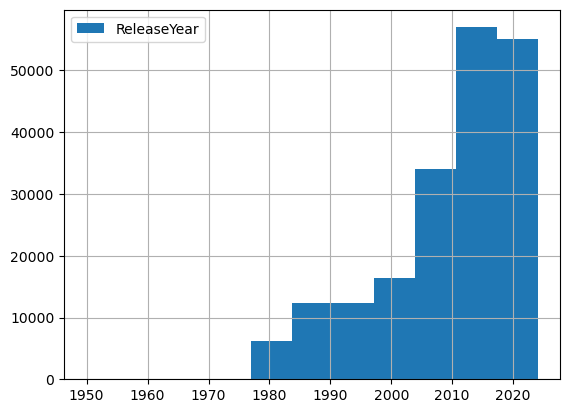

In [24]:
year_hist = movies_df['ReleaseYear'].hist(bins=11, legend=True)

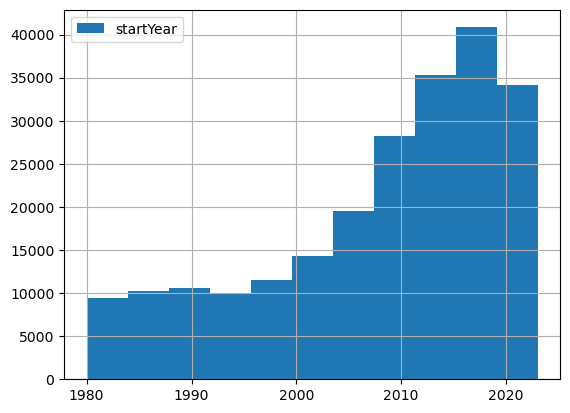

In [25]:
year_hist2 = movies_df['startYear'].hist(bins=11, legend=True)

In [26]:
movies_df['ReleaseYear'].value_counts()

2019.0    10032
2022.0     9795
2018.0     9596
2017.0     9462
2021.0     9085
2016.0     8863
2015.0     8804
2020.0     8600
2014.0     8330
2023.0     7943
2013.0     7804
2012.0     7095
2011.0     6629
2010.0     5839
2009.0     5730
2008.0     5471
2007.0     4889
2006.0     4518
2005.0     4026
2004.0     3607
2003.0     3333
2002.0     3083
2001.0     2876
2000.0     2545
1999.0     2365
1998.0     2143
1997.0     1983
1989.0     1855
1986.0     1817
1990.0     1810
1988.0     1800
1996.0     1800
1987.0     1772
1995.0     1756
1993.0     1726
1985.0     1719
1994.0     1705
1991.0     1705
1992.0     1674
1982.0     1668
1984.0     1623
1983.0     1587
1981.0     1579
1980.0     1434
2024.0       59
1979.0        3
1978.0        1
1977.0        1
1959.0        1
1950.0        1
Name: ReleaseYear, dtype: int64

In [27]:
movies_df['startYear'].value_counts()

2019    10449
2018    10339
2017    10269
2022     9918
2016     9782
2015     9395
2014     9172
2021     8837
2013     8552
2020     8379
2012     8190
2011     7791
2010     7208
2023     7050
2009     6947
2008     6228
2007     5421
2006     5193
2005     4656
2004     4220
2003     3821
2002     3673
2001     3519
2000     3258
1999     3114
1998     2926
1997     2853
1989     2721
1988     2672
1987     2661
1996     2656
1990     2631
1986     2602
1995     2601
1991     2562
1985     2535
1984     2490
1993     2471
1994     2468
1992     2465
1983     2452
1982     2395
1981     2355
1980     2265
Name: startYear, dtype: int64

In [28]:
movies_df['genres'].value_counts()

Drama                        37105
Documentary                  29885
Comedy                       16583
Comedy,Drama                  7856
Horror                        6430
                             ...  
Adventure,News                   1
History,Horror,Mystery           1
Action,Adult,Horror              1
Action,Documentary,Horror        1
Animation,Crime,Music            1
Name: genres, Length: 1159, dtype: int64

In [29]:
movies_df['OMDB_Genre'].value_counts()

Drama                                           36949
Documentary                                     29774
Comedy                                          16569
Comedy, Drama                                    7641
                                                 7418
                                                ...  
Animation, Comedy, Fantasy, History, Romance        1
Short, Drama, Romance                               1
Action, Adventure, Drama, Thriller                  1
Biography, Crime, Drama, History, War               1
Animation, Crime, Music                             1
Name: OMDB_Genre, Length: 1828, dtype: int64

In [30]:
genre_counts = movies_df['genres'].value_counts()
genre_counts.loc[lambda x : x > 1000]

Drama                    37105
Documentary              29885
Comedy                   16583
Comedy,Drama              7856
Horror                    6430
N                         6407
Drama,Romance             5832
Thriller                  4181
Comedy,Romance            3774
Comedy,Drama,Romance      3745
Action                    3672
Drama,Thriller            2722
Action,Crime,Drama        2375
Horror,Thriller           2271
Romance                   2266
Crime,Drama               2018
Action,Drama              1867
Documentary,Music         1782
Adult                     1749
Biography,Documentary     1659
Crime,Drama,Thriller      1540
Comedy,Horror             1382
Drama,Family              1281
Family                    1218
Action,Thriller           1065
Documentary,History       1026
Crime                     1008
Action,Comedy             1005
Documentary,Drama         1002
Name: genres, dtype: int64

# Reduce genre to a single category prioritized by basic genres in priority of uniqueness / original counts
Ref: https://www.premiumbeat.com/blog/guide-to-basic-film-genres/ for primary list <br>
Combine the following categories: 
* Documentary to include Biography, Histroy, News in addition to Documentary
* Sci-Fi to include both Sci Fi & Fantasy
* Action include both Action, Adventure, & Sport
* Music to include Music & Musical
* Drama to include Drama & War
* Mystery to include Mystery & Crime
* Family to include Family & Animation
* Categories left as is: Comedy, Horror, Thriller, Romance, Western
* Unknown will include '0' and the Reality-TV (21) + Talk-Show (7)
Using counts of movies with single genre out of this ~220k list and uniqueness of category, the priority:
0. Adult
1. Comedy
2. Horror
3. Thriller
4. Romance
5. Western
6. Drama
7. Documentary
8. Action
9. Family
10. Mystery
11. Sci-Fi
12. Music
13. Unknown

In [31]:
# Grab start time
start_time = time.time()

# Loop through every row of the movies_df
for index, row in movies_df.iterrows():
    # print something to indicate still working...
    if index%50000 == 0:
        print(f'working on index: {index}')
    
    # grab the genre cell
    movie_genres = row['genres']

    # Only take action if the cell is populated 
    if movie_genres != "" :
        # Convert the comma separated list of directors into a list
        genre_list = movie_genres.split(",")

        # if there is only one value, substitue to reduced genre category list as appropriate; 
        # Comedy, Horror, Thriller, Romance, Adult, Western, Documentary, Sci-Fi, Action, Music, Drama, Mystery, Family will not change
        if len(genre_list) == 1:
            if genre_list[0] in ['Biography', 'History', 'News']:
                movies_df.loc[index,'genres'] = 'Documentary'
            elif genre_list[0] == 'Fantasy':
                movies_df.loc[index,'genres'] = 'Sci-Fi'
            elif genre_list[0] in ['Adventure', 'Sport']:
                movies_df.loc[index,'genres'] = 'Action'
            elif genre_list[0] == 'Musical':
                movies_df.loc[index,'genres'] = 'Music'
            elif genre_list[0] == 'War':
                movies_df.loc[index,'genres'] = 'Drama'
            elif genre_list[0] == 'Crime':
                movies_df.loc[index,'genres'] = 'Mystery'
            elif genre_list[0] == 'Animation':
                movies_df.loc[index,'genres'] = 'Family'
            elif genre_list[0] in ['Reality-TV', 'Talk-Show', 0, '0']:
                movies_df.loc[index,'genres'] = 'Unknown'
        if len(genre_list) > 1:
            if any(item in genre_list for item in ['Adult']):
                movies_df.loc[index,'genres'] = 'Adult'
            elif any(item in genre_list for item in ['Comedy']):
                movies_df.loc[index,'genres'] = 'Comedy'
            elif any(item in genre_list for item in ['Horror']):
                movies_df.loc[index,'genres'] = 'Horror'
            elif any(item in genre_list for item in ['Thriller']):
                movies_df.loc[index,'genres'] = 'Thriller'
            elif any(item in genre_list for item in ['Romance']):
                movies_df.loc[index,'genres'] = 'Romance'
            elif any(item in genre_list for item in ['Western']):
                movies_df.loc[index,'genres'] = 'Western'
            elif any(item in genre_list for item in ['Drama', 'War']):
                movies_df.loc[index,'genres'] = 'Drama'
            elif any(item in genre_list for item in ['Documentary', 'Biography', 'History', 'News']):
                movies_df.loc[index,'genres'] = 'Documentary'
            elif any(item in genre_list for item in ['Action', 'Adventure', 'Sport']):
                movies_df.loc[index,'genres'] = 'Action'
            elif any(item in genre_list for item in ['Family', 'Animation']):
                movies_df.loc[index,'genres'] = 'Family'
            elif any(item in genre_list for item in ['Mystery', 'Crime']):
                movies_df.loc[index,'genres'] = 'Mystery'
            elif any(item in genre_list for item in ['Sci-Fi', 'Fantasy']):
                movies_df.loc[index,'genres'] = 'Sci-Fi'
            elif any(item in genre_list for item in ['Music', 'Musical']):
                movies_df.loc[index,'genres'] = 'Music'
            elif any(item in genre_list for item in ['Reality-TV', 'Talk-Show', 0, '0']):
                movies_df.loc[index,'genres'] = 'Unknown'


# Print time taken
print("--- %s seconds ---" % round((time.time() - start_time),2))

movies_df['genres'].value_counts()

working on index: 0
working on index: 50000
working on index: 100000
working on index: 150000
working on index: 200000
--- 45.49 seconds ---


Drama          60382
Comedy         52383
Documentary    41049
Horror         16508
Thriller       15936
Romance        12332
Action          9255
N               6407
Family          2805
Adult           2545
Mystery         1690
Sci-Fi          1330
Music            920
Western          592
Unknown           28
Name: genres, dtype: int64

## Notes on feature distributions:
* OMDB_Rated had 20 categories with overlap which have been reduced to 4 categories: kids (G, PG), teens (PG13), adults(NC-17+, R), and unknown
* There are differences between Release Year and Start Year - if we use this feature, we need to better understand the meaning
* The original IMDB genre appeared easier to clean than OMWD_genre

# Investigate Output / Target Compares between two sources

In [32]:
movies_df.groupby(['OMDB_Rated'])['averageRating'].mean()

OMDB_Rated
adults     5.588824
kids       6.153435
teens      6.011403
unknown    6.281808
Name: averageRating, dtype: float64

In [33]:
movies_df.groupby(['OMDB_Rated'])['OMDB_imdbRating'].mean()

OMDB_Rated
adults     5.585786
kids       6.119384
teens      5.994875
unknown    6.159476
Name: OMDB_imdbRating, dtype: float64

In [34]:
movies_df.groupby(['OMDB_Rated'])['averageRating'].count()

OMDB_Rated
adults      19417
kids         6943
teens        8068
unknown    189734
Name: averageRating, dtype: int64

In [35]:
movies_df.groupby(['OMDB_Rated'])['OMDB_imdbRating'].count()

OMDB_Rated
adults      19136
kids         6686
teens        7863
unknown    155741
Name: OMDB_imdbRating, dtype: int64

The r-squared is: 0.4510722012581637


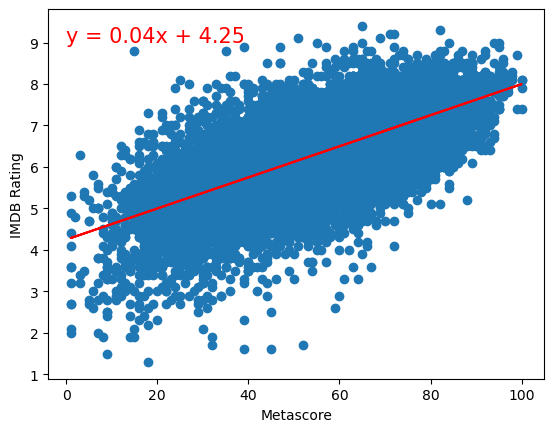

In [36]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_Metascore', 'averageRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_Metascore']
y_values = movies_df_no_nan['averageRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,9),fontsize=15,color="red")
plt.xlabel('Metascore')
plt.ylabel('IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.45070547760025675


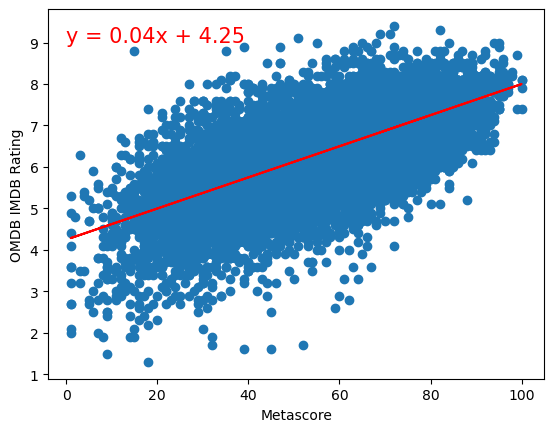

In [37]:
# Define the x and y
movies_df_no_nan = movies_df[['OMDB_Metascore', 'OMDB_imdbRating']]
movies_df_no_nan = movies_df_no_nan.dropna()

x_values = movies_df_no_nan['OMDB_Metascore']
y_values = movies_df_no_nan['OMDB_imdbRating']

# Calculate the regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the different factors in a scatter plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,9),fontsize=15,color="red")
plt.xlabel('Metascore')
plt.ylabel('OMDB IMDB Rating')

print(f"The r-squared is: {rvalue**2}")
plt.show()

## Notes on outputs / targets:
* The OMDB entry for IMDB ratings does not align perfectly with ratings reported directly from IMDB. For the purposes of this project timeline, they are close enough to not dig into further

# Export final file

In [38]:
movies_df.head()

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,genres,Movie,OMDB_Title,OMDB_Rated,...,OMDB_Actors,OMDB_Language,OMDB_Country,OMDB_Metascore,OMDB_imdbRating,OMDB_imdbVotes,OMDB_BoxOffice,OMDB_Production,ReleaseYear,ReleaseMonth
0,tt10048376,4.8,30,0,2019,101.0,Drama,Ya podaryu tebe pobedu,Ya podaryu tebe pobedu,unknown,...,"Tigran Agadzhanyan, Maria Atlas, Valeriy Barinov",Russian,Russia,NaN,5.1,22.0,NaN,,2019.0,4.0
1,tt10048556,3.7,340,0,2019,88.0,Thriller,Staged Killer,Staged Killer,teens,...,"Chrishell Stause, Nicole Bilderback, Jason Dolley",English,United States,NaN,3.7,339.0,NaN,,2019.0,6.0
2,tt10049110,7.8,96,0,2019,93.0,Documentary,Die Wiese,Die Wiese,unknown,...,Sebastian Winkler,German,Germany,NaN,7.8,95.0,NaN,,2019.0,4.0
3,tt10049238,7.1,41,0,2018,61.0,Documentary,Joan Miró: The Inner Fire,Miró contra Miró,unknown,...,"Hester Wilcox, Joan Miró, Joan Punyet Miró","Spanish, French, English","France, Spain",NaN,7.0,32.0,NaN,,2018.0,10.0
4,tt10049262,5.4,176,0,2020,107.0,Comedy,James & Pat & Dave,James & Pat & Dave,unknown,...,"Ronnie Alonte, Loisa Andalio, Donny Pangilinan","Tagalog, Filipino",Philippines,NaN,5.4,174.0,NaN,,2020.0,2.0


In [40]:
movies_df.to_csv("../Resources/IMDB_OMDB_processed.csv")